# A4 Classification of Hand-Drawn Digits

In this assignment, you will define a new class named `NeuralNetworkClassifier` that extends the `NeuralNetwork` class provided here and is the solution to Assignment A2.  You will use `NeuralNetworkClassifier` to train a classifier of hand-drawn digits.

You will also define the function `confusion_matrix`.

## `NeuralNetwork` class

In [1]:
import matplotlib.pyplot as plt

The following code cell will write its contents to `optimizers.py` so the `import optimizers` statement in the code cell after it will work correctly.

In [3]:
%%writefile optimizers.py
import numpy as np

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing m, v, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Overwriting optimizers.py


In [4]:
import numpy as np
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        # Unstandardize output Y before returning it
        return Y * self.Tstds + self.Tmeans

Adam: Epoch 25 Error=0.23386
Adam: Epoch 50 Error=0.21142
Adam: Epoch 75 Error=0.18621
Adam: Epoch 100 Error=0.14336
Adam: Epoch 125 Error=0.09700
Adam: Epoch 150 Error=0.07372
Adam: Epoch 175 Error=0.06427
Adam: Epoch 200 Error=0.05821
Adam: Epoch 225 Error=0.05320
Adam: Epoch 250 Error=0.04876


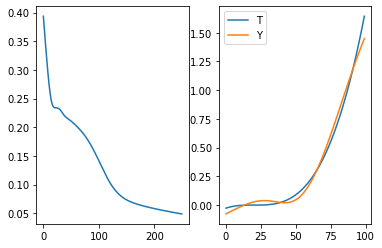

In [5]:
X = np.arange(100).reshape((-1, 1))
T = (X - 20) ** 3 / 300000

hiddens = [10]
nnet = NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, 250, 0.01, method='adam')

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

plt.subplot(1, 2, 2)
plt.plot(T, label='T')
plt.plot(nnet.use(X), label='Y')
plt.legend()

## Your `NeuralNetworkClassifier` class

Complete the following definition of `NeuralNetworkClassifier` as discussed in class. You will need to override the functions

* `train`
* `error_f`
* `gradient_f`
* `use`

and define the following new functions

* `makeIndicatorVars`
* `softmax`

In [ ]:
class NeuralNetworkClassifier(NeuralNetwork):
    
    . . .

Here is a simple test of your new class.  For inputs from 0 to 100, classify values less than or equal to 25 as Class Label 25, greater than 25 and less than or equal to 75 as Class Label 75, and greater than 75 as Class Label 100. 

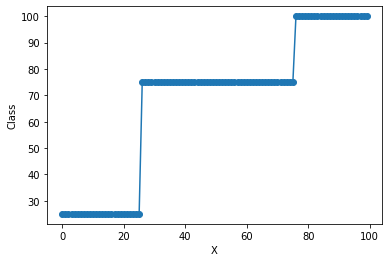

In [7]:
X = np.arange(100).reshape((-1, 1))
T = X.copy()
T[T <= 25] = 25
T[np.logical_and(25 < T, T <= 75)] = 75
T[T > 75] = 100

plt.plot(X, T, 'o-')
plt.xlabel('X')
plt.ylabel('Class');

Adam: Epoch 20 Error=0.78542
Adam: Epoch 40 Error=0.84530
Adam: Epoch 60 Error=0.89318
Adam: Epoch 80 Error=0.92608
Adam: Epoch 100 Error=0.94462
Adam: Epoch 120 Error=0.95520
Adam: Epoch 140 Error=0.96188
Adam: Epoch 160 Error=0.96651
Adam: Epoch 180 Error=0.96995
Adam: Epoch 200 Error=0.97264


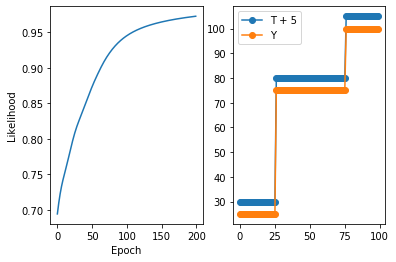

In [8]:
hiddens = [10]
nnet = NeuralNetworkClassifier(X.shape[1], hiddens, len(np.unique(T)))
nnet.train(X, T, 200, 0.01, method='adam', verbose=True)

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T + 5, 'o-', label='T + 5')  # to see, when predicted overlap T very closely
plt.plot(nnet.use(X)[0], 'o-', label='Y')
plt.legend()

## Now for the Hand-Drawn Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

deeplearning.net goes down a lot.  If you can't download it from there you can try getting it from [here](https://gitlab.cs.washington.edu/colinxs/neural_nets/blob/master/mnist.pkl.gz).

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [9]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [10]:
Ttrain[:10]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4]])

Those must be the digits.  What the heck is in those 784 columns in the input matrices?

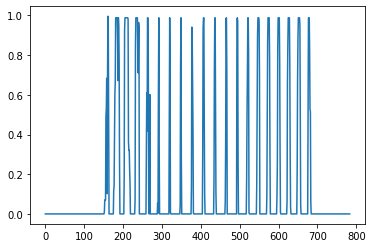

In [11]:
plt.plot(Xtrain[0, :]);

Well, values between 0 and 1.  That doesn't help much.  These are actually intensity values for 784 pixels in an image.

How can we rearrange these values into an image to be displayed?  We must first figure out how many columns and rows the image would have.  Perhaps the image is a square image, with equal numbers of rows and columns.

In [12]:
import math
math.sqrt(784)

28.0

Ah, cool.

In [13]:
28 * 28

784

Ok Let's reshape it and look at the numbers.

In [14]:
image0 = Xtrain[0, :]
image0 = image0.reshape(28, 28)
image0

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

Not that helpful.  Ok, let's use `matplotlib` to make an image display.

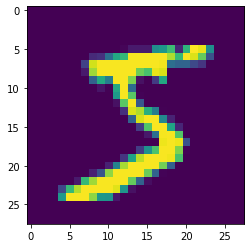

In [15]:
plt.imshow(image0);

Humm.  Try a grayscale color map.

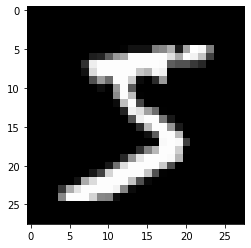

In [16]:
plt.imshow(image0, cmap='gray');

With a little more work, we can make it look like a pencil drawing.

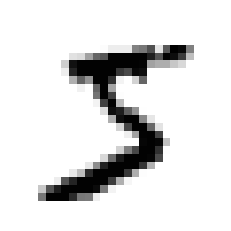

In [17]:
plt.imshow(-image0, cmap='gray')  # notice the negative sign
plt.axis('off');

Looks like a 5.  What class label is associated with this image?

In [18]:
Ttrain[0]

array([5])

Okay.  Makes sense.  Let's look at the first 100 images and their labels, as plot titles.

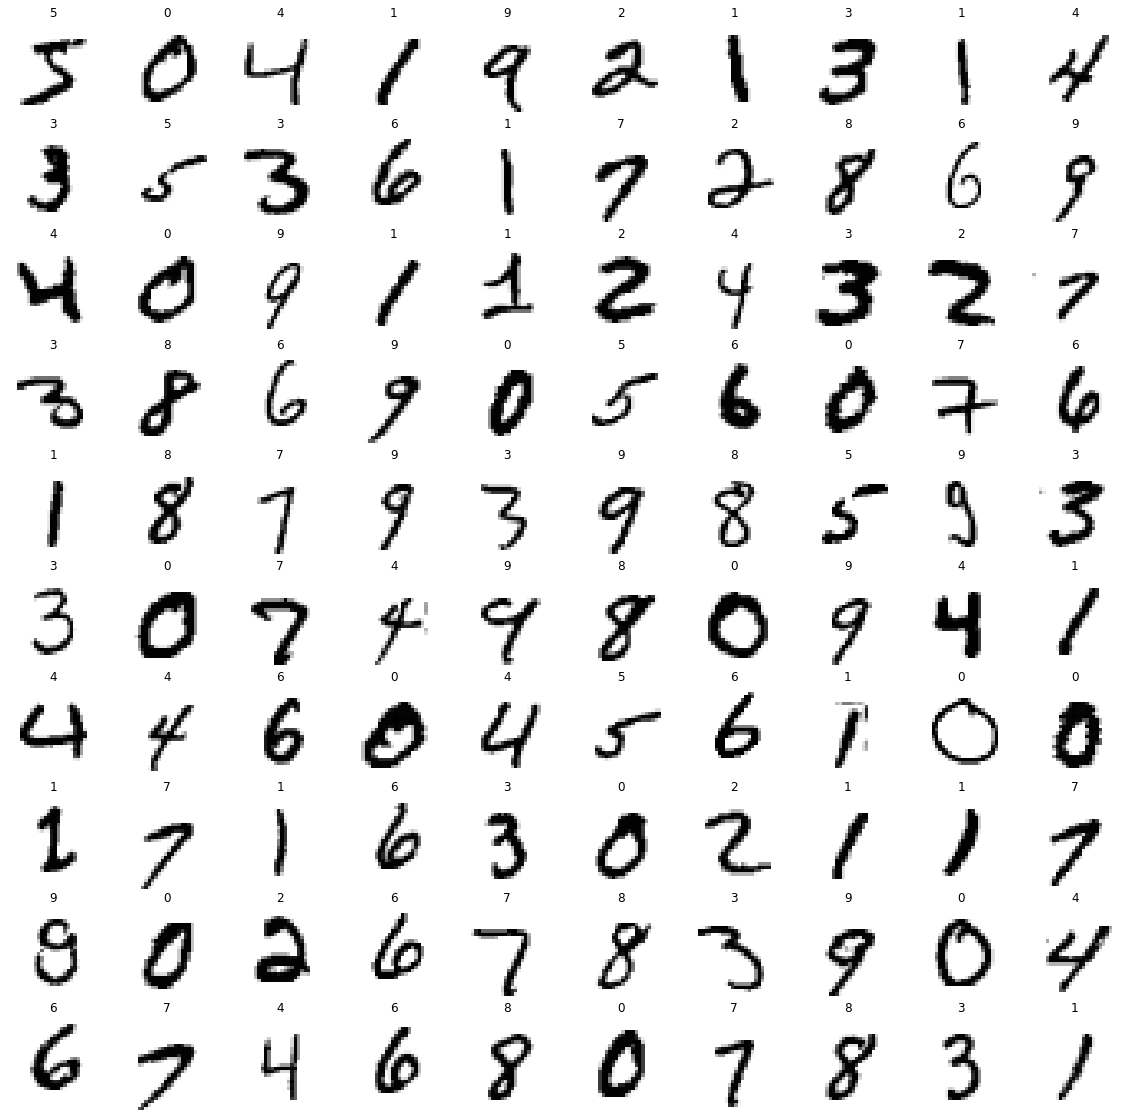

In [19]:
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(-Xtrain[i, :].reshape(28, 28), cmap='gray')
    plt.title(Ttrain[i, 0])
    plt.axis('off');

Okay.  We are ready to try to classify, right?

First we should check the proportions of each digit in the given data partitions.

In [20]:
classes = np.arange(10)
(Ttrain == classes).shape

(50000, 10)

In [21]:
(Ttrain == classes).sum(axis=0)

array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988])

In [22]:
(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]

array([0.09864, 0.11356, 0.09936, 0.10202, 0.09718, 0.09012, 0.09902,
       0.1035 , 0.09684, 0.09976])

In [23]:
['Ttrain', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]]

['Ttrain',
 0.09864,
 0.11356,
 0.09936,
 0.10202,
 0.09718,
 0.09012,
 0.09902,
 0.1035,
 0.09684,
 0.09976]

In [24]:
import pandas

result = []
result.append(['Train', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]])
result.append(['Tval', *(Tval == classes).sum(axis=0) / Tval.shape[0]])
result.append(['Ttest', *(Ttest == classes).sum(axis=0) / Ttest.shape[0]])
pandas.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,10
0,Train,0.09864,0.11356,0.09936,0.10202,0.09718,0.09012,0.09902,0.1035,0.09684,0.09976
1,Tval,0.09910,0.10640,0.09900,0.10300,0.09830,0.09150,0.09670,0.1090,0.10090,0.09610
2,Ttest,0.09800,0.11350,0.10320,0.10100,0.09820,0.08920,0.09580,0.1028,0.09740,0.10090


All very close to 0.1. Super.

Time for our first experiment.  Let's train a small neural net with 5 hidden units in one layer for a small number of epochs using Adam.

In [25]:
n_epochs = 100
learning_rate = 0.01

np.random.seed(142)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

Adam: Epoch 10 Error=0.82887
Adam: Epoch 20 Error=0.85170
Adam: Epoch 30 Error=0.87229
Adam: Epoch 40 Error=0.88913
Adam: Epoch 50 Error=0.90202
Adam: Epoch 60 Error=0.91179
Adam: Epoch 70 Error=0.91932
Adam: Epoch 80 Error=0.92541
Adam: Epoch 90 Error=0.93041
Adam: Epoch 100 Error=0.93447


NeuralNetworkClassifier(784, [5], 10, 'tanh')

In [26]:
print(nnet)  # uses the __str__ method

NeuralNetworkClassifier(784, [5], 10, 'tanh') trained for 100 epochs, final training error 0.9345


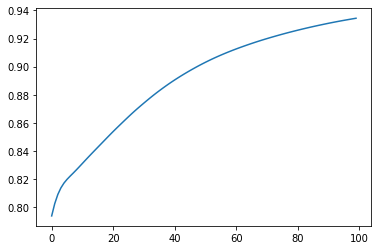

In [27]:
plt.plot(nnet.error_trace);

Now it is time for you to run some longer experiments.  You must write the code to do the following steps:

1. For each of at least five different hidden layer structures

    1. Train a network for 500 epochs.
    1. Collect percent of samples correctly classified in the given train, validate, and test partitions.

2. Create a `pandas.DataFrame` with these results and with column headings `('Hidden Layers', 'Train', 'Validate', 'Test', 'Time')` where `'Time'` is the number of seconds required to train each network.

3. Retrain a network using the best hidden layer structure, judged by the percent correct on the validation set.
4. Use this network to find several images in the test set for which the network's probability of the correct class is the closest to zero, meaning images for which your network does the worst.  Draw these images and discuss why your network might not be doing well for those images.

## `confusion_matrix`

Now, write a function named `confusion_matrix` that returns a confusion matrix for any classification problem, returned as a `pandas.DataFrame` as shown in Lecture Notes 12.  It must require two arguments, the predicted classes for each sample and the true classes for each sample.  Here is an example.

In [28]:
Y_classes, Y_probs = nnet.use(Xtest)
confusion_matrix(Y_classes, Ttest)

,0,1,2,3,4,5,6,7,8,9
0,89.897959,0.204082,1.530612,0.000000,1.326531,1.020408,3.877551,1.326531,0.204082,0.612245
1,0.176211,94.625551,1.321586,1.233480,0.264317,0.176211,0.352423,0.088106,1.762115,0.000000
2,1.162791,1.647287,85.658915,2.228682,1.356589,0.387597,3.294574,0.872093,3.100775,0.290698
3,0.000000,0.792079,8.514851,77.821782,0.693069,3.663366,2.376238,1.683168,3.465347,0.990099
4,0.814664,1.120163,1.120163,0.407332,82.179226,1.731161,0.610998,1.018330,0.407332,10.590631
5,2.690583,0.336323,1.233184,3.139013,1.793722,74.887892,4.708520,0.896861,6.726457,3.587444
6,3.131524,0.208768,3.027140,0.626305,0.521921,5.323591,84.237996,2.400835,0.313152,0.208768
7,1.167315,3.015564,1.361868,0.875486,2.918288,0.000000,0.583658,84.241245,0.000000,5.836576
8,1.129363,1.848049,0.821355,6.262834,0.513347,7.905544,1.129363,1.334702,76.591376,2.464066
9,2.081269,1.288404,0.000000,0.991080,5.748266,1.189296,0.000000,3.567889,1.090188,84.043608


## Grading and Check-In

You will receive 70 points for correct code, and 30 points for other results and your discussions.  As before, you can test your code against the grading script yourself by downloading [A4grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A4grader.zip) and extracting `A4grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the in the following cell to see an example grading run.  Submit assignments **through Canvas** following the pattern of the previous assignments. *Do not send your file to the instructor/TA via email or any other medium!*

In [ ]:
%run -i A4grader.py

## Extra Credit
Earn 5 extra credit point on this assignment by doing the following.

1. Combine the train, validate, and test partitions loaded from the MNIST data file into two matrices, `X` and `T`. 
2. Using `adam` , `relu` and just one value of `learning_rate` and `n_epochs`, compare several hidden layer architectures. Do so by applying our `generate_k_fold_cross_validation_sets` function as defined in Lecture Notes 10 which forms stratified partitioning, for use in classification problems, to your `X` and `T` matrices using `n_fold` of 3.
3. Show results and discuss which architectures you find works the best, and how you determined this.